# Partial Fourier Transform 
Computations and practice

In [81]:
from numpy import *
import matplotlib.pyplot as plt
%matplotlib notebook
from scipy.linalg import block_diag
import scipy.sparse as ss
import scipy.sparse.linalg as ssl

In [28]:
import warnings
warnings.filterwarnings('ignore')

## 1D chain

Take the simple 1D model with 

$$\begin{equation}
H = -t \sum_{j} c^{\dagger}_{j+1} c_{j} + c^{\dagger}_{j} c_{j+1}
\end{equation}$$

Here we assume periodic boundary conditions.

By Fourier transforming we know that $E_k = -2t \cos(k)$.

<IPython.core.display.Javascript object>


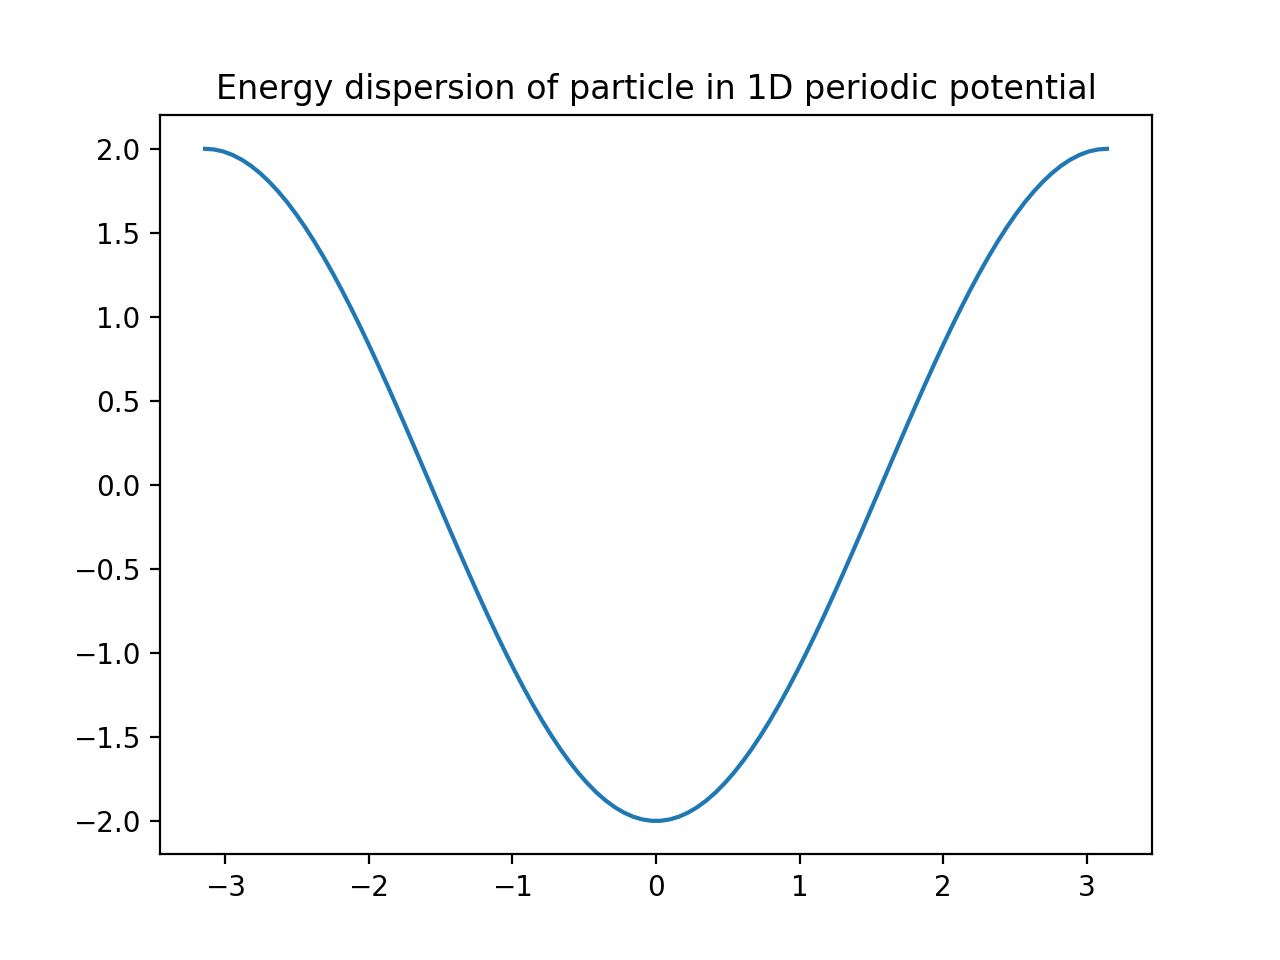

<IPython.core.display.Javascript object>


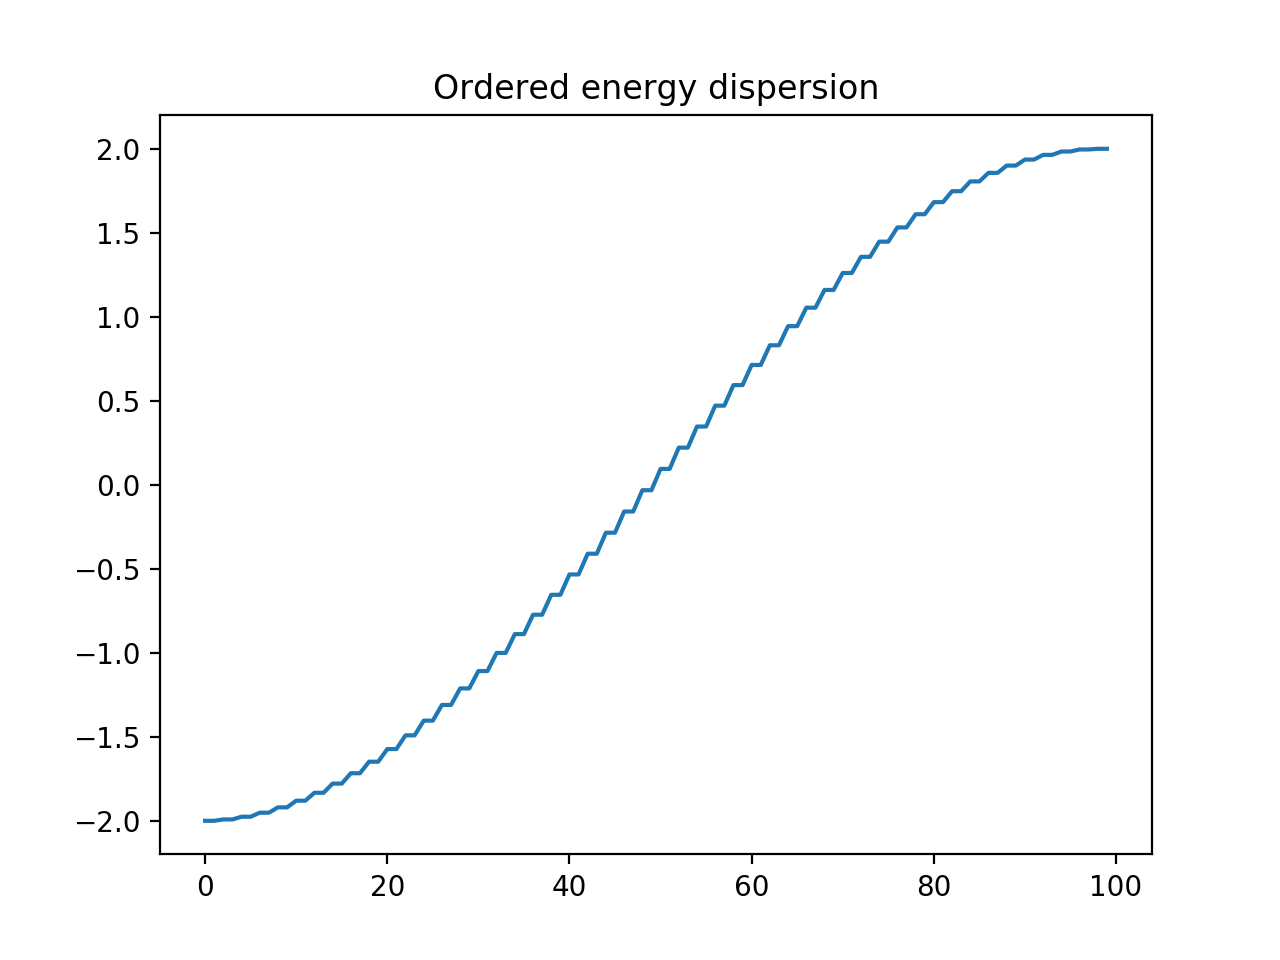

In [216]:
ks = linspace(-np.pi,np.pi,100,endpoint=True)
E_k = -2 * cos(ks)

plt.figure()
plt.title("Energy dispersion of particle in 1D periodic potential")
plt.plot(ks, E_k)
plt.show()

plt.figure()
plt.title("Ordered energy dispersion")
plt.plot(np.linspace(0,len(E_k),len(E_k), endpoint = False), sort(E_k))
plt.show()

Let's see if we can get this same (sorted) dispersion without fourier transforming, i.e. in real space algebra.

In [217]:
def H_mat_1D(size, t = 1):
    size = int(size)
    H_off_diag_up = diag(-t*ones(size-1),k=1)
    H_off_diag_down = diag(-t*ones(size-1),k=-1)
    H = H_off_diag_down + H_off_diag_up
    #H[0,size-1] = -t
    #H[size-1,0] = -t
    return H

<IPython.core.display.Javascript object>


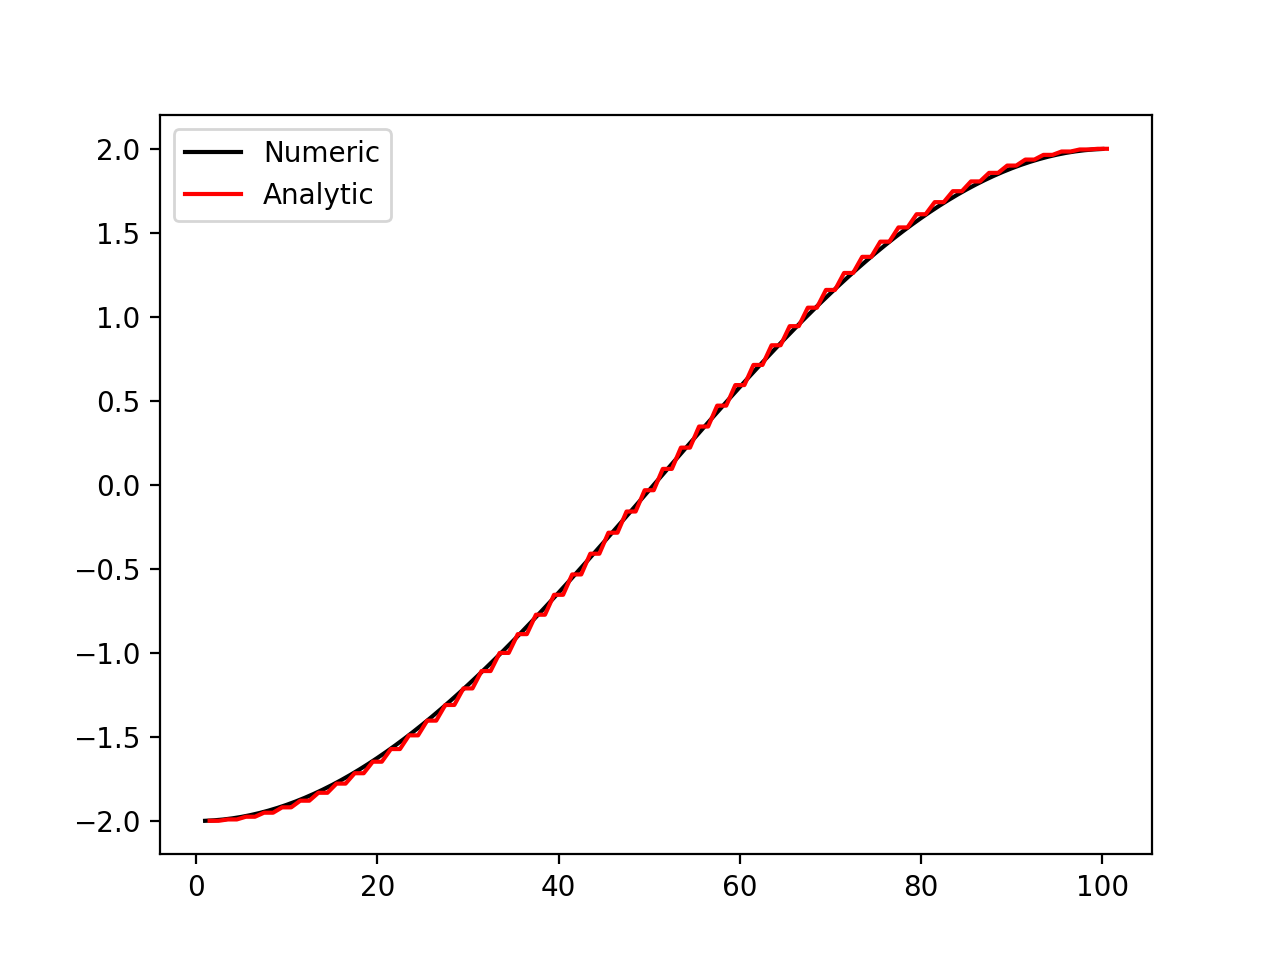

In [233]:
N = 100
H = H_mat_1D(size=N)
eigs = linalg.eigvalsh(H)
ns = linspace(1,len(eigs),len(eigs), endpoint = True)
del_k = pi/N

plt.figure()
plt.plot(ns, eigs,c='k',label="Numeric")
plt.plot(np.linspace(1,len(E_k),len(E_k), endpoint = True)+0.5, sort(E_k), c='r', label = "Analytic")
plt.legend()
plt.show()

The boundary $t$'s cause the step-like appearance. Looks the same! However, we lose some information as to the form of the plot $k \text{ vs } E$

Can we recover $k$'s from `ns`?

In [226]:
k_rec = zeros(len(ns))

for i in range(len(ns)):
    n = ns[i]
    n_new = ceil(n/2)
    k_rec[i] = (-1)**n * n_new * 2*pi/N

<IPython.core.display.Javascript object>


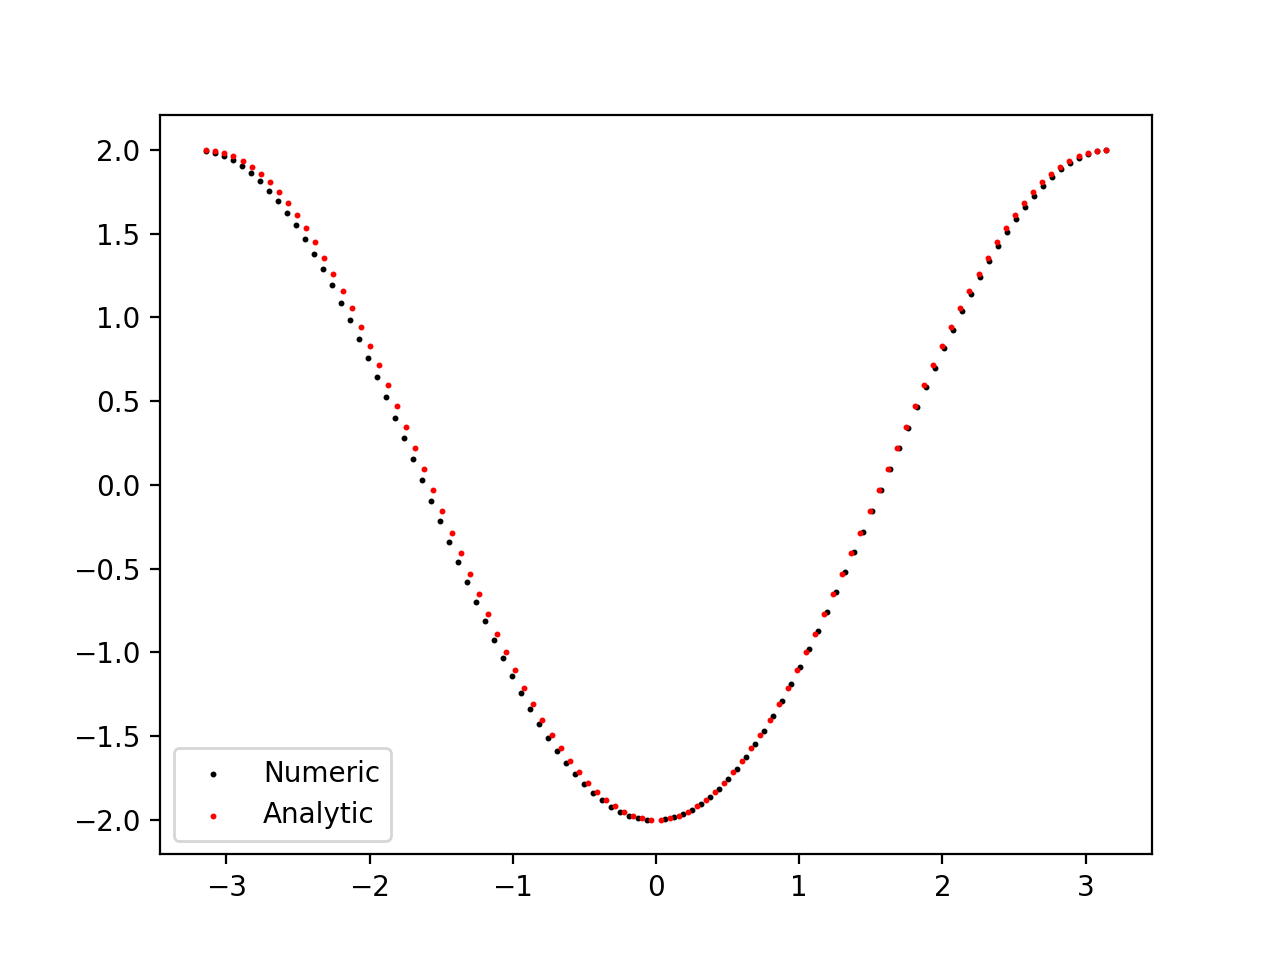

In [239]:
plt.figure()
plt.scatter(k_rec,eigs,marker='.',s=5,c='k',label='Numeric')
plt.scatter(ks,E_k, marker='.',s=5,c='r',label='Analytic')
plt.legend()
plt.show()

Yes we can!

Open questions:
- Bulk or boundary? How do we impose cutoff w/o these -t terms in the corners?
- Difference between this and what we did previously, which was to have a $k$ dependent matrix and calculate eigenvalues as a function of $k$? Perhaps this will become more apparent as we move on.

## 2D lattice

We now look at the 2D lattice model. We'll do a partial FT, leaving the x direction in real space.

$$\begin{equation}
H = -t \sum_x 2 \cos k_y c^{\dagger}_{x,k_y} c_{x,k_y} + c^{\dagger}_{x+1,k_y} c_{x,k_y} + c^{\dagger}_{x,k_y} c_{x+1,k_y}
\end{equation}$$

We know from Fourier analysis that the energy spectrum will be of the form $$ E_{k_x, k_y} = -2t \space (\cos k_x + \cos k_y) $$

<IPython.core.display.Javascript object>


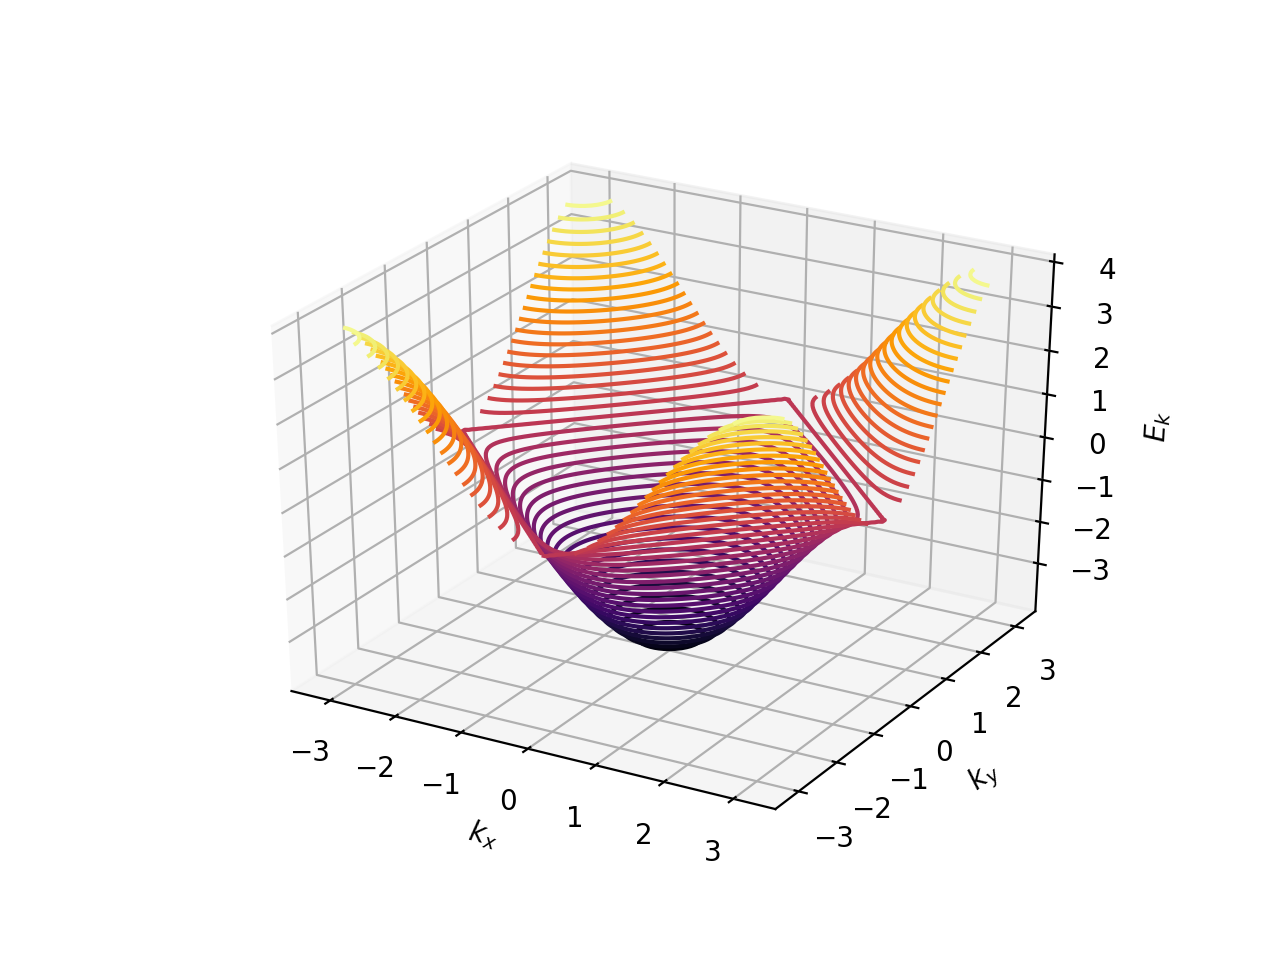

In [120]:
k_x = linspace(-pi,pi,num=100,endpoint=True)
k_y = linspace(-pi,pi,num=100,endpoint=True)

K_x, K_y = meshgrid(k_x,k_y)
E_k = -2 * (cos(K_x) + cos(K_y))

from mpl_toolkits import mplot3d

plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(K_x, K_y, E_k, 50, cmap='inferno')
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
ax.set_zlabel(r'$E_k$')
plt.show()

<IPython.core.display.Javascript object>


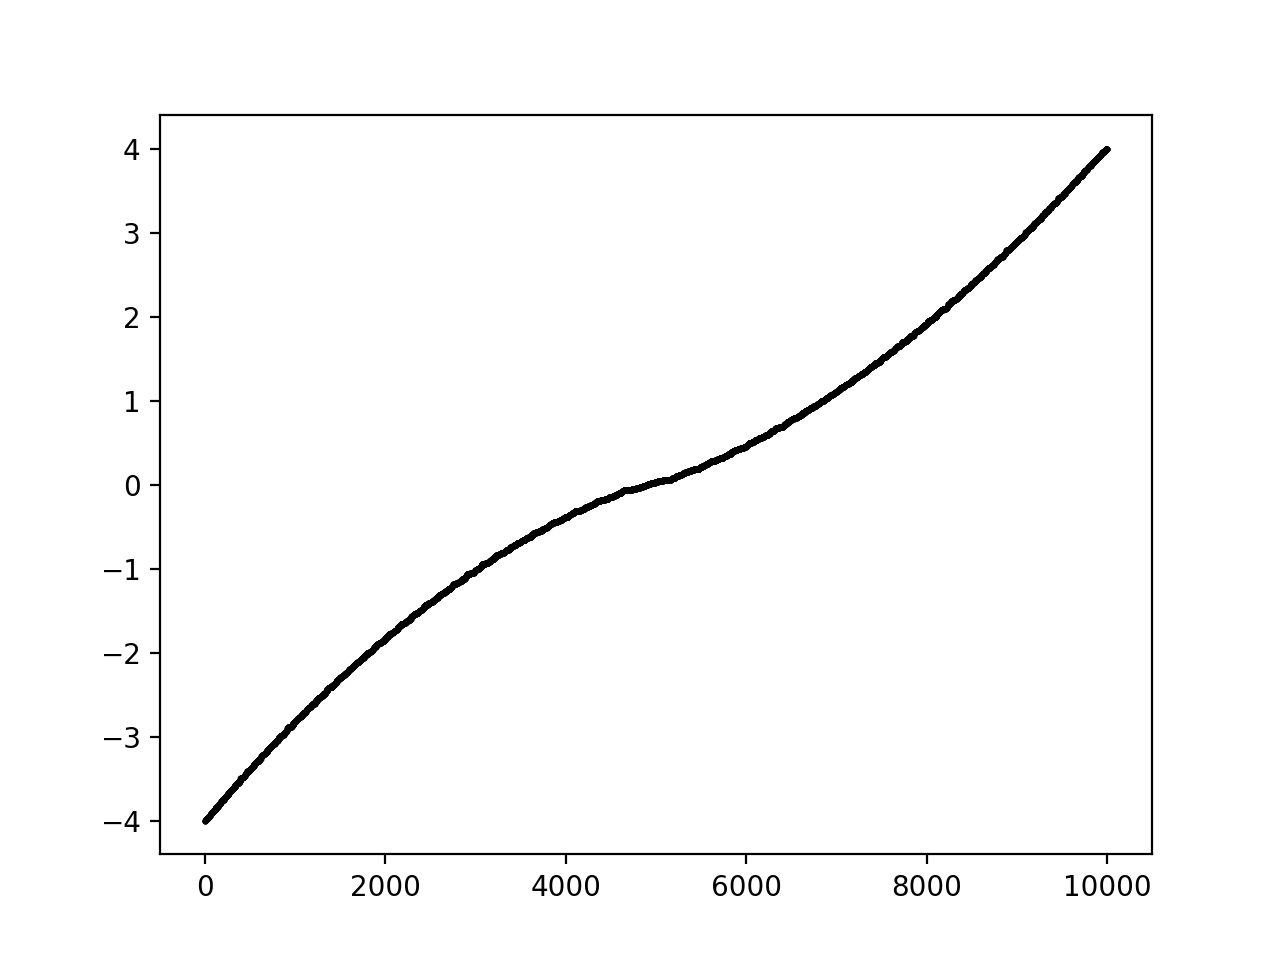

In [129]:
# once again, sort the energies to get something comparable
E_k_flat = sort(ndarray.flatten(E_k))

# plot it
plt.figure()
plt.scatter(linspace(1,len(E_k_flat),num=len(E_k_flat),endpoint=True),E_k_flat,c='k',marker='.',s=5)
plt.show()

To investigate this numerically we let $H$ will be diagonal in $k_y$ and use the real space represtantion of $x$ (i.e partial transform in $y$). It will have a familiar form within those block diagonals. 

In [235]:
def nu_block(size,nu,t=1):
    """
    Matrix to go in diagonal of 2D model
    """
    # diags
    diags = diag([2*cos(nu)]*size)
    nsh = diag(-t*ones(size-1), k=1) + diag(-t*ones(size-1), k=-1)
    M = diags + nsh
    #M[0,size-1] = -t
    #M[size-1,0] = -t
    return M

def H_mat_2D(size,t=1):
    """
    2D Hamiltonian matrix partially FT in y with dimensions N_x*N_y x N_x*N_y
    """
    # make block to go in diagonal
    blocks = zeros((size,size,size))
    nus = linspace(-pi,pi,size,endpoint = True)
    for i in range(size):
        nu = nus[i]
        blocks[i,:,:] = nu_block(size,nu=nu,t=t)
        
    # use sparse.block_diag instead of scipy.ditto because it takes in an array
    H = ss.block_diag(blocks).toarray() # <- still needs testing
    return H

In [236]:
# calculate the eigenvalues and plot them
N_2 = 100
H_2D = H_mat_2D(size=N_2)
eigs_2D = ssl.eigsh(H_2D, k = int(N_2**2), return_eigenvectors=False) # <- recall H is N**2 x N**2
eigs_2D = sort(eigs_2D)

<IPython.core.display.Javascript object>


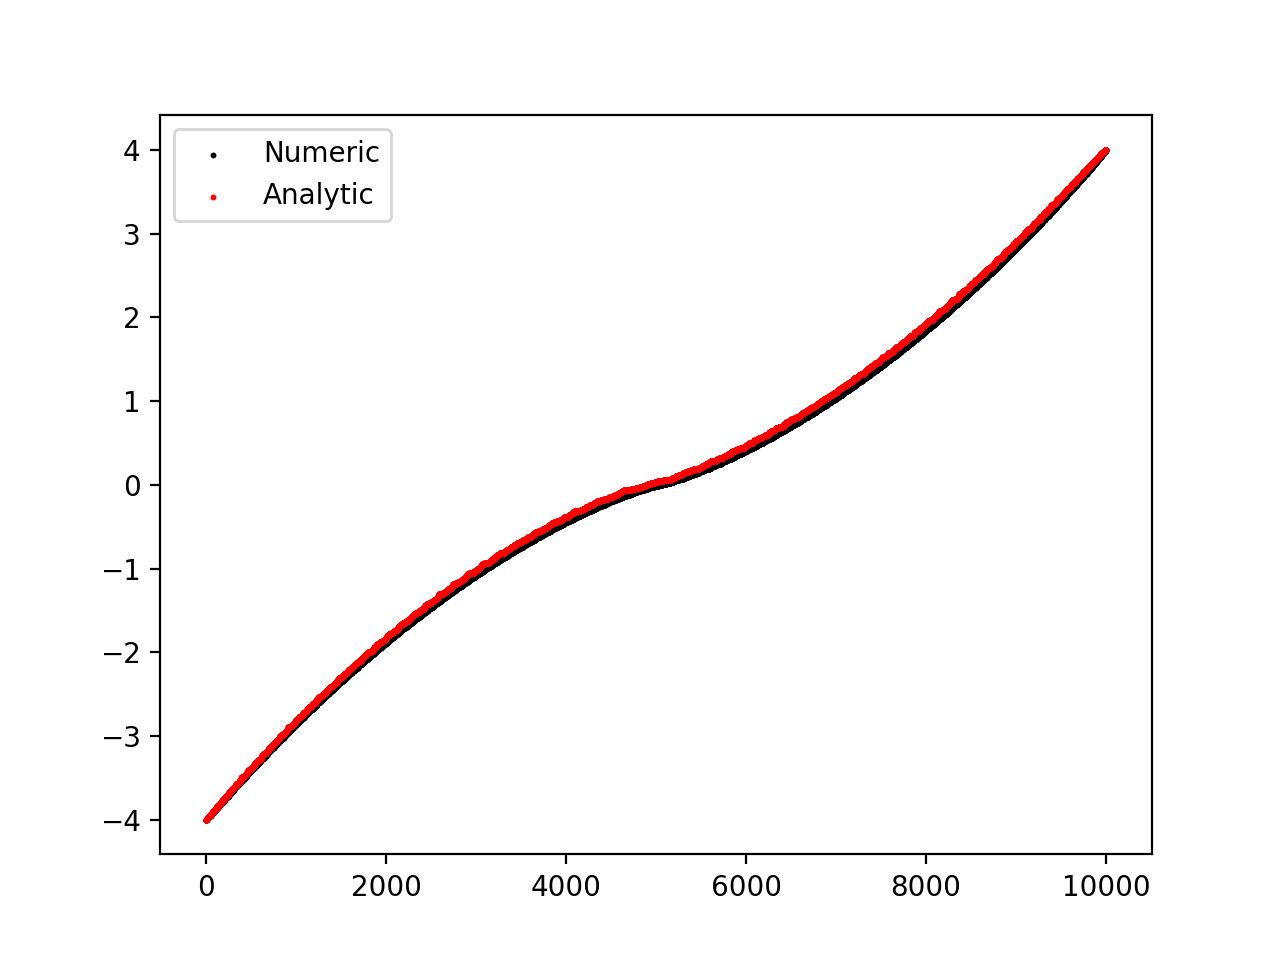

In [252]:
ns_2 = linspace(1,N_2**2,num=N_2**2,endpoint=True)

plt.figure()
plt.scatter(ns_2,eigs_2D,c='k',marker='.',s=5,label='Numeric')
plt.scatter(linspace(0,len(E_k_flat),num=len(E_k_flat),endpoint=False),E_k_flat,
            c='red',marker='.',s=5, label = 'Analytic')
plt.legend()
plt.show()

Open questions:
- Discrepancy between analytic and numeric is not completely negligible. Does it have to do with the treatment of boundary conditions?

## 2D lattice with $B$ (Peierls)

This is the same as the 2D lattice but now there is a gauge field $\vec{A} = Bx\hat{y}$. This leads to the Peierls substitution

$$ k_y \rightarrow k_y - \frac{By}{\phi_0}$$

How will this affect the Hamiltonian?

We'll use $\Phi = p/q$ as the $\vec{B}$ parameter.

The "analytic", or fully Fourier transformed energy spectrum is found by diagonalizing the Harper matrix.


In [303]:
def eigs_harper(p, q, nu = 0, mu = 0):
    # takes in p and q (and thus the ratio of p and q)
    # returns an m x m matrix with 2cos(2pi*phi*m) on the diagonal
    # 1s on the off diagonals
    # 1s in the corners (periodic boundary conditions)
    
    #define size
    size = int(q)
    # makes coses
    coses = [2*np.cos(2*np.pi*(p/q)*m - nu) for m in range(q)]
    # fill up H
    C = np.diag(coses)
    G = np.diag(np.ones(size-1), -1) + np.diag(np.ones(size-1), 1)
    #G = G.astype('complex128')
    #G[0,size-1] = np.exp(1j * mu * q)
    #G[size-1, 0] = np.exp(-1j * mu * q)
    H = G + C
    
    #calculate eigs
    eigs = np.linalg.eigvalsh(H)
    
    # return eigs
    return list(eigs)

In [304]:
# take p = 27 and q = 100
p_B = 27
q_B = 100
eigs_ana = []

for nu in linspace(-pi,pi,num=q_B,endpoint=True):
    eigs_ana_nu = eigs_harper(p=p_B,q=q_B,nu=nu)
    eigs_ana.extend(eigs_ana_nu)

<IPython.core.display.Javascript object>


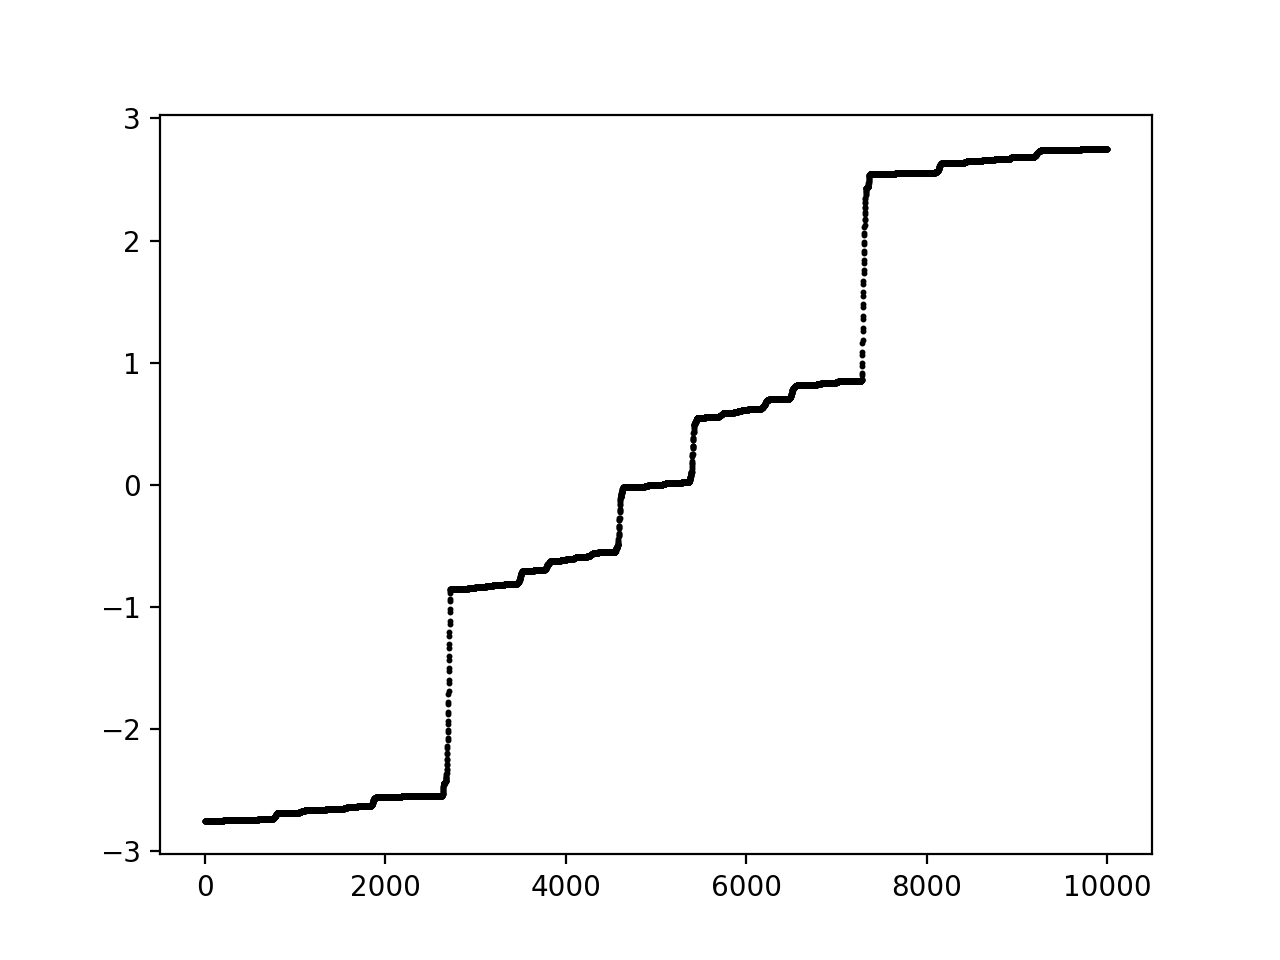

In [305]:
plt.figure()
plt.scatter(linspace(1,len(eigs_ana),num=len(eigs_ana),endpoint=True),sort(eigs_ana),c='k',marker='.',s=5)
plt.show()

In [259]:
def peierls_block(size,p,q,nu,t=1):
    """
    Block to go into diagonal of H_peierls
    """
    if int(size) != int(q):
        raise Exception("size must be the same as q")
        return
    # diags
    Phi = p/q
    coses = [2*cos(2*pi*Phi*m - nu) for m in range(size)]
    diags = diag(coses)
    nsh = diag(ones(size-1), k=1) + diag(ones(size-1), k=-1)
    M = diags + nsh
    M *= -t

    return M

def H_peierls(size,p,q,t=1):
    """
    Hamiltonian for a particle in a magnetic field PFT in y
    """
    size = int(size)
    
    # make block to go in diagonal
    blocks = zeros((size,size,size))
    nus = linspace(-pi,pi,size,endpoint = True)
    for i in range(size):
        nu = nus[i]
        blocks[i,:,:] = peierls_block(size=size,p=p,q=q,nu=nu,t=t)
        
    # use sparse.block_diag instead of scipy.ditto because it takes in an array
    H = ss.block_diag(blocks).toarray() # <- still needs testing
    
    return H

In [282]:
# calculate the eigenvalues and plot them
N_B = 100
H_B = H_peierls(size=N_B,p=p_B,q=q_B)
eigs_B = ssl.eigsh(H_B, k = int(N_B**2), return_eigenvectors=False) # <- recall H is N**2 x N**2
eigs_B = sort(eigs_B)

<IPython.core.display.Javascript object>


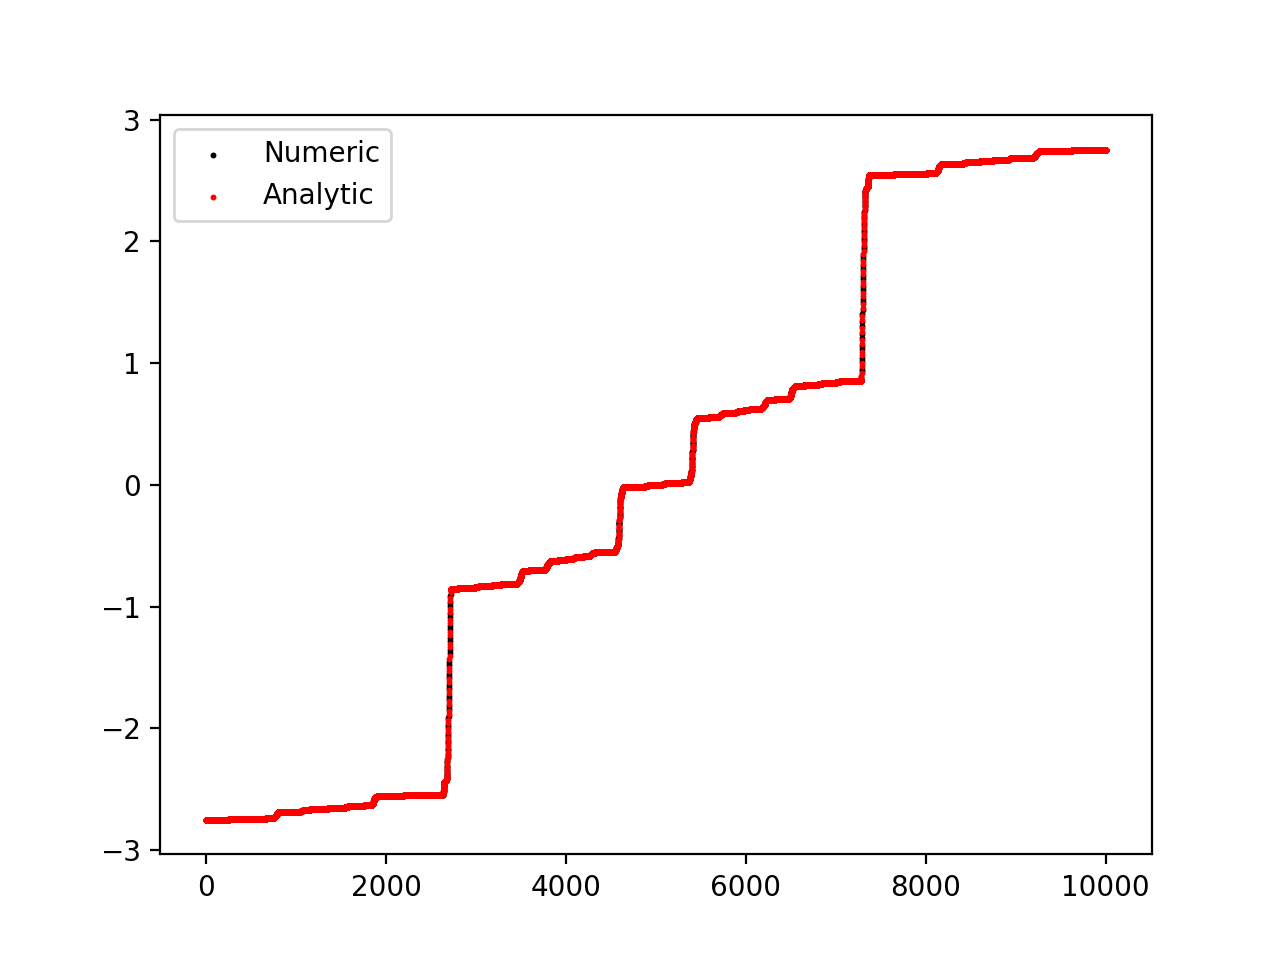

In [307]:
ns_B = linspace(1,N_B**2,num=N_B**2,endpoint=True)

plt.figure()
plt.scatter(ns_B,eigs_B,c='k',marker='.',s=5,label='Numeric')
plt.scatter(linspace(1,len(eigs_ana),num=len(eigs_ana),endpoint=True),
            sort(eigs_ana),c='r',marker='.',s=5,label='Analytic')
plt.legend()
plt.show()

The boundary terms caused for a split in the energies. Now, they are all connected.

# 3D SOTI

We'll do the same thing for the second order topological insulator. That is, we Fourier transform in $z$ only, leaving the $x$ and $y$ dimensions in real space. The Hamiltonian $H = H(x,y,k_z)$ is

$$\begin{align}
H =& \sum_{x,y,k_z}\{[M \sigma_{0} \tau_{z} + t \cos(2 \pi \Phi y - \eta) \sigma_{0} \tau_{z} + \Delta_{1} \sin (2 \pi \Phi y - \eta) \sigma_{z} \tau_{x}] c_{x,y,k_z}^{\dagger} c_{x,y,k_z} \\
&+\frac{1}{2}(t \sigma_{0} \tau_{z}+i \Delta_{1} \sigma_{x} \tau_{x} + \Delta_{2} \sigma_{0} \tau_{y}) c_{x+1,y,k_z}^{\dagger} c_{x,y,k_z} + \frac{1}{2}(t \sigma_{0} \tau_{z} - i \Delta_{1} \sigma_{x} \tau_{x} + \Delta_{2} \sigma_{0} \tau_{y}) c_{x,y,k_z}^{\dagger} c_{x+1,y,k_z}\\
&+ \frac{1}{2}(t \sigma_{0} \tau_{z}+i \Delta_{1} \sigma_{y} \tau_{x} - \Delta_{2} \sigma_{0} \tau_{y}) c_{x,y+1,k_z}^{\dagger} c_{x,y,k_z} + \frac{1}{2}(t \sigma_{0} \tau_{z}-i \Delta_{1} \sigma_{y} \tau_{x} - \Delta_{2} \sigma_{0} \tau_{y}) c_{x,y,k_z}^{\dagger} c_{x,y+1,k_z} \}
\end{align}$$

The form of this matrix is loaded in the function `H_SOTI`.

In [33]:
from soti_pft_tools import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


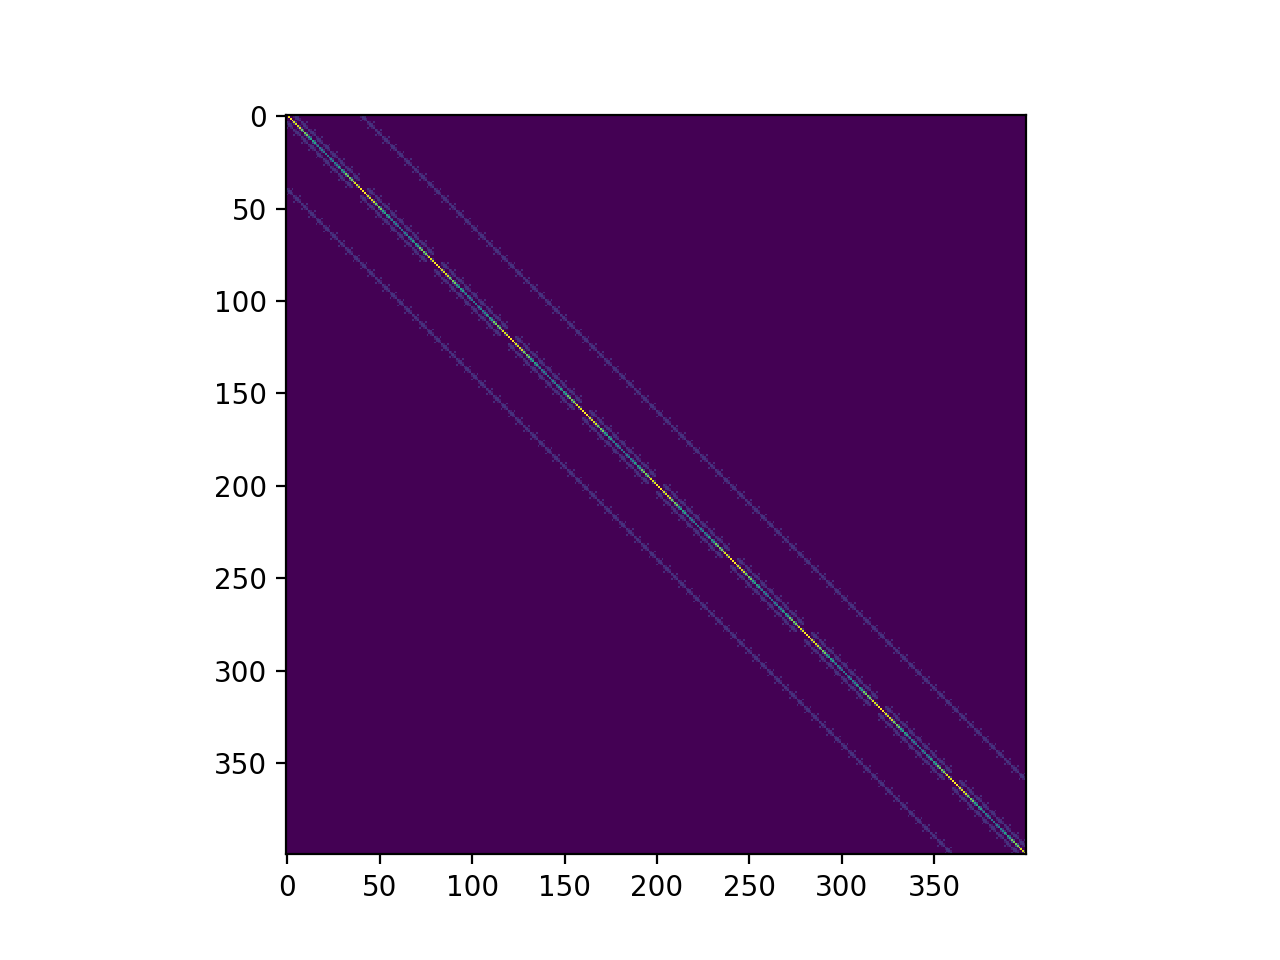

In [351]:
test = soti_block(10,p=1,q=10,zu=0)
plt.figure()
plt.imshow(abs(test))
plt.show()

There are some cuts on the off diagonals. This is because of how the blocks are stacked. (Look at soti_tools result and compare).

Calculate the energies.

In [12]:
# calculate the eigenvalues and plot them
N_s = 10
p_s = 2
q_s = N_s
H_s = H_SOTI(size=N_s,p=p_s,q=q_s)
eigs_s = ssl.eigsh(H_s, k = int(4*N_s**3), return_eigenvectors=False) # <- recall H is N**2 x N**2
eigs_s = sort(eigs_s)

<IPython.core.display.Javascript object>


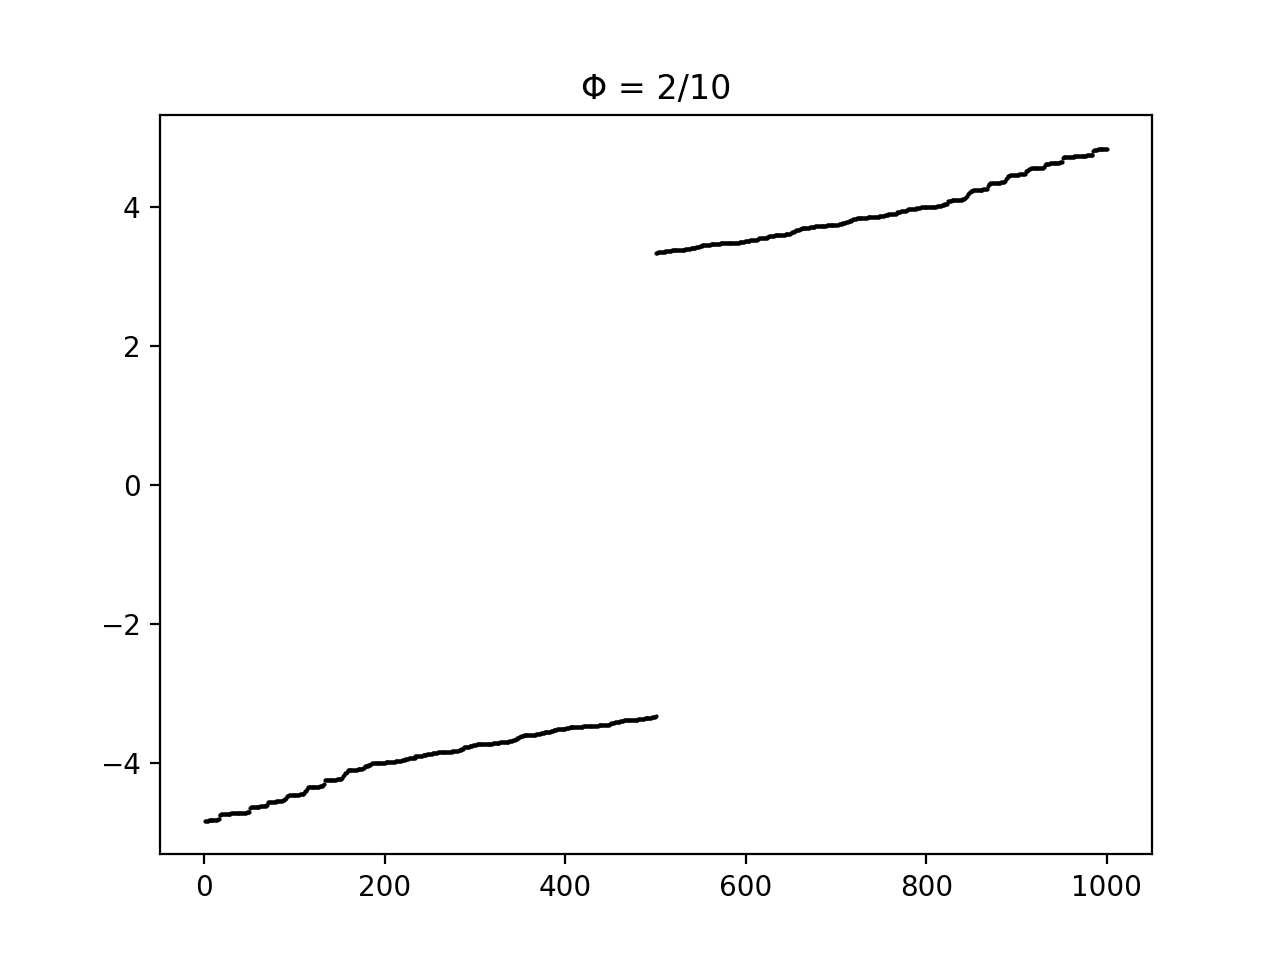

In [13]:
plt.figure()
plt.title("Φ = 2/10")
plt.scatter(linspace(1,len(eigs_s),num=len(eigs_s)),eigs_s,c='k',marker='.',s=1)
plt.show()

<IPython.core.display.Javascript object>


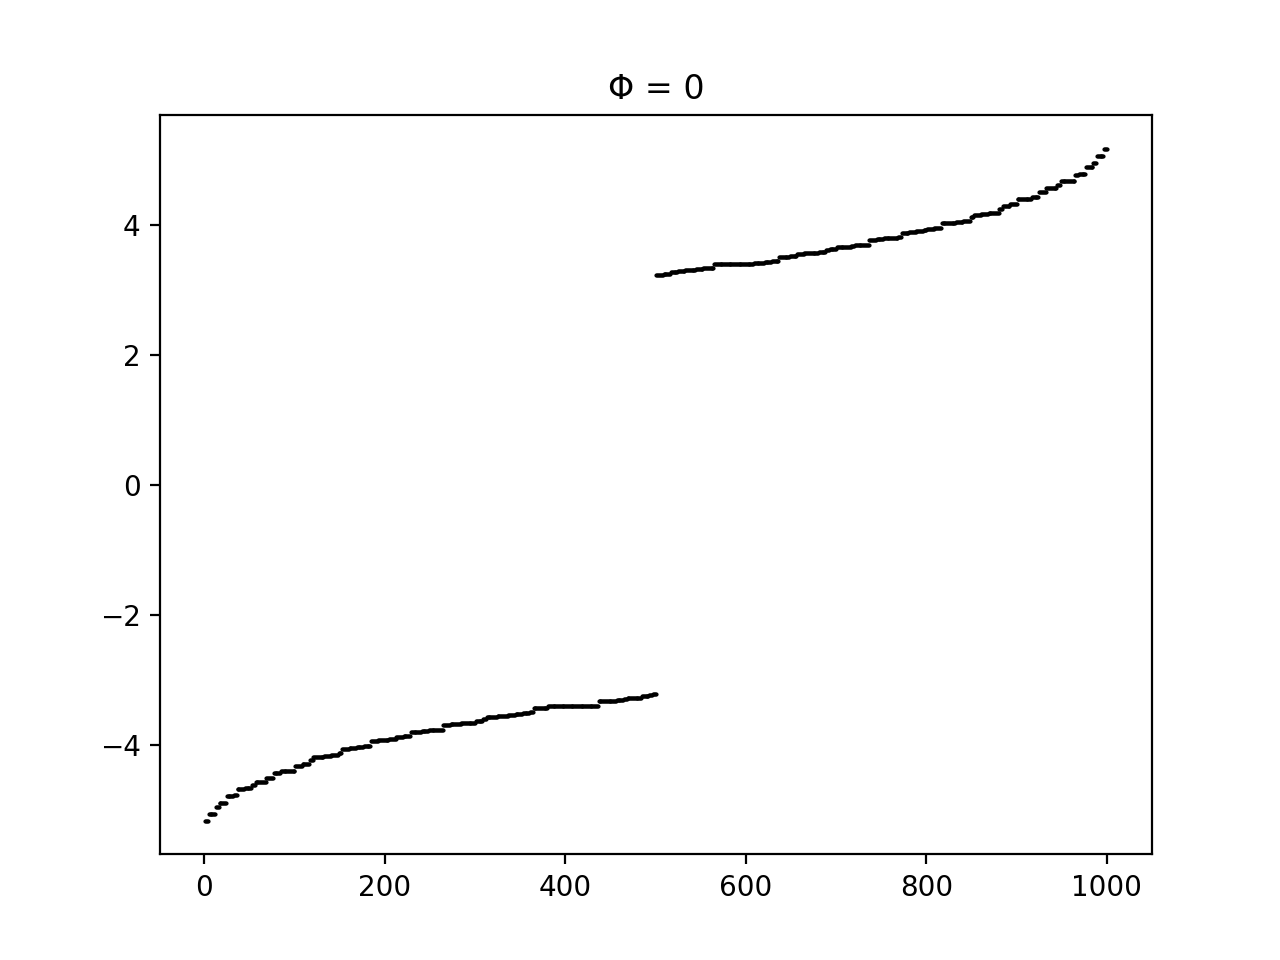

In [11]:
plt.figure()
plt.title("Φ = 0")
plt.scatter(linspace(1,len(eigs_s),num=len(eigs_s)),eigs_s,c='k',marker='.',s=1)
plt.show()

Try just diagonalizing a `soti_block` and plot as a function of $k_z$

In [27]:
N_kz = 20
kz, E_kz = kz_spectrum(N_kz,0,N_kz,kz_res=N_kz)

/Users/leogoutte/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1269: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


<IPython.core.display.Javascript object>


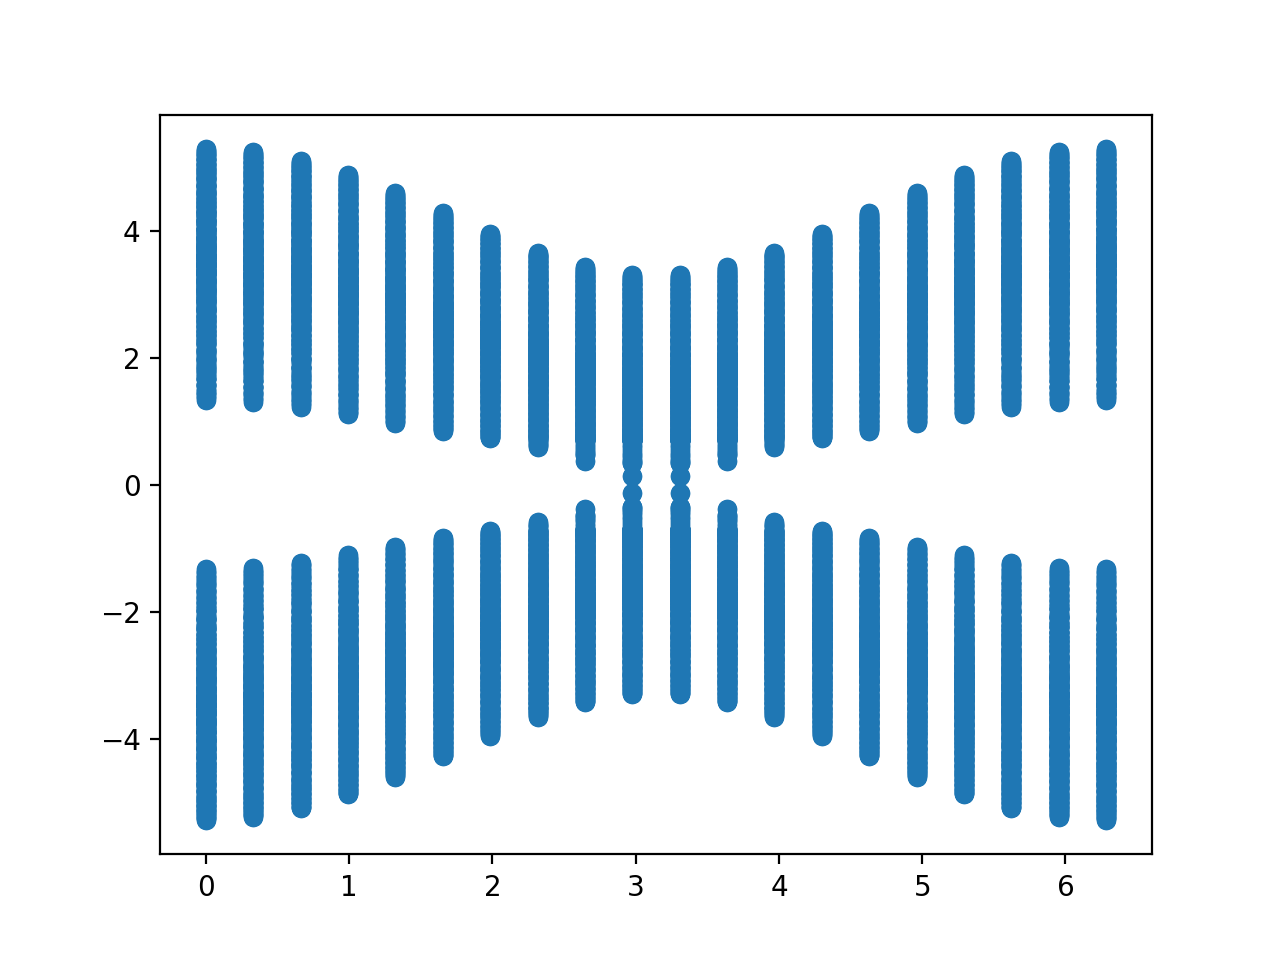

In [26]:
plt.figure()
plt.scatter(kz,E_kz,c='k',s='5',marker='.')
plt.show()

<IPython.core.display.Javascript object>


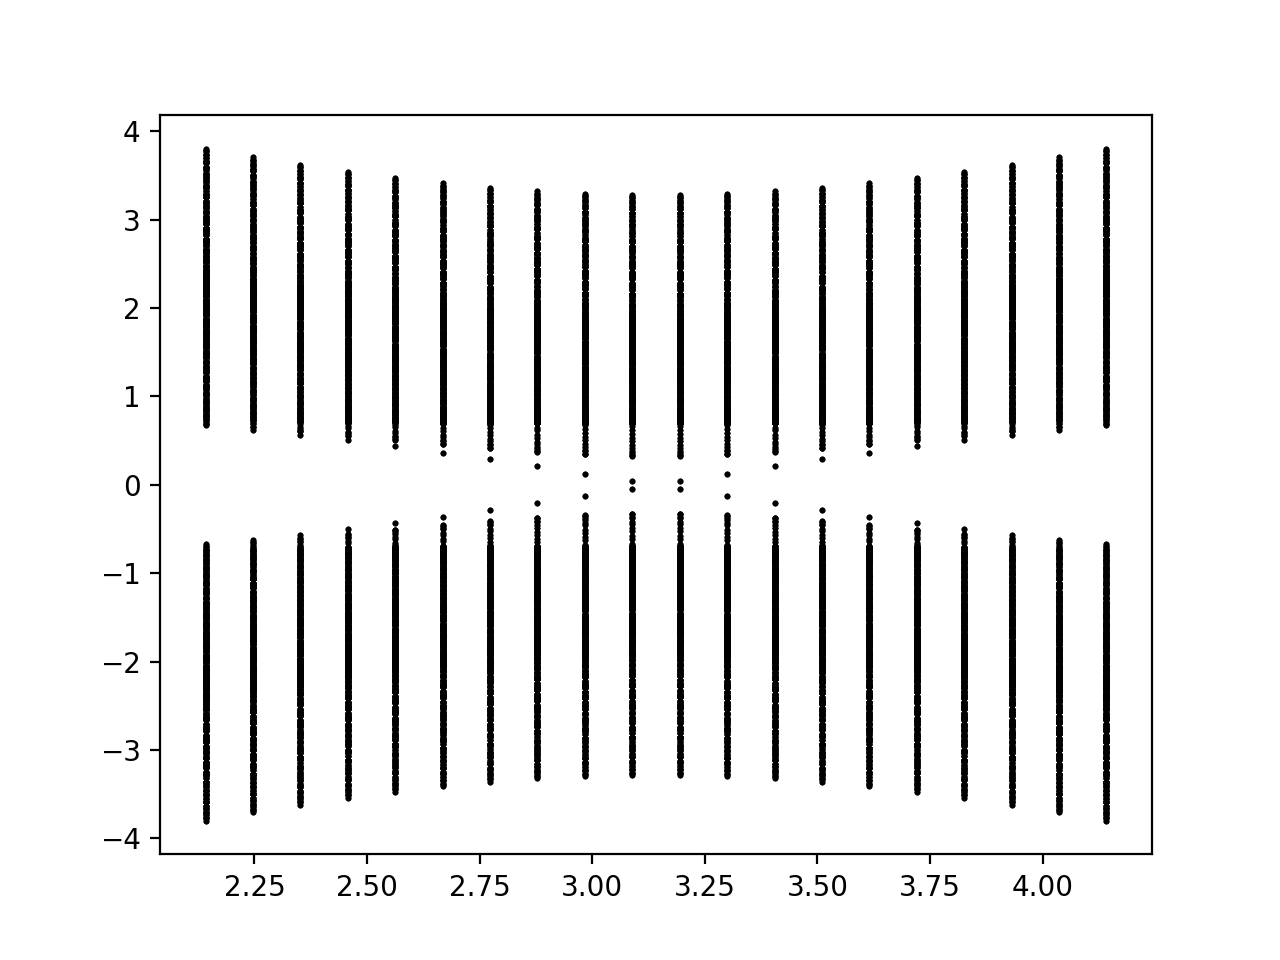

In [31]:
plt.figure()
plt.scatter(kz,E_kz,c='k',s=5,marker='.')
plt.show()

What is the $\Phi$ dependency? We'll need to essentially marginalize over all $k_z$ like we did before for $k_x$ ($\mu$) and $k_y$ ($\nu$). Write a `.py` script that can be run for large $q$ on a `CC` cluster. 

This function is `sum_over_kz`

In [ ]:
phi_cs, eps_cs = sum_over_kz(qmax=25,kz_res=5)

In [ ]:
plt.figure()
plt.scatter(eps_cs,phi_cs,c='k',s=0.1,marker='.')
plt.show()